In [82]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
import pandas as pd
from seminartools.models.four_quarter_average_model import FourQuarterAverageModel
from seminartools.data import read_merged
from seminartools.data import read_inflation

# 1. Read data

In [84]:
df = read_merged().reset_index()
df

,country,date,inflation,gdp_growth,interest_rate,unemployment_rate,commodity_CRUDE_PETRO,commodity_iNATGAS,commodity_iAGRICULTURE,commodity_iMETMIN,commodity_iPRECIOUSMET
0,Japan,1977-01-01,0.022951,2.187257,6.333333,2.3,0.00000,0.052425,0.144757,0.041940,0.112740
1,Canada,1977-01-01,0.023904,1.533830,8.166667,8.8,0.00000,0.052425,0.144757,0.041940,0.112740
2,United States,1977-01-01,0.017231,1.186233,4.700000,8.2,0.00000,0.052425,0.144757,0.041940,0.112740
3,Japan,1977-04-01,0.027244,0.703788,5.000000,2.0,-0.00400,0.043586,-0.066688,-0.045412,-0.060029
4,Canada,1977-04-01,0.023346,0.510302,7.666667,8.0,-0.00400,0.043586,-0.066688,-0.045412,-0.060029
...,...,...,...,...,...,...,...,...,...,...,...
2166,Italy,2023-01-01,0.003938,0.552944,3.000000,8.3,-0.02041,-0.585458,0.002037,0.007418,0.043183
2167,Canada,2023-01-01,0.006080,0.610026,4.500000,5.4,-0.02041,-0.585458,0.002037,0.007418,0.043183
2168,Sweden,2023-01-01,0.014955,0.656897,2.833333,7.8,-0.02041,-0.585458,0.002037,0.007418,0.043183
2169,Korea,2023-01-01,0.010538,0.329875,3.500000,3.2,-0.02041,-0.585458,0.002037,0.007418,0.043183


In [85]:
from seminartools.models.utils import get_stats
from seminartools.models.four_quarter_average_model import FourQuarterAverageModel
from seminartools.models.pca_var_model import PCAVARModel
from seminartools.models.armax_model import ARMAXModel
from seminartools.models.uc_sv_ss_model import UCSVSSModel
from seminartools.models.random_effects_model import RandomEffectsModel
from seminartools.models.distance_model import DistanceModel
from seminartools.time_series_split import ExpandingWindowSplit

exog_columns = [
    "gdp_growth",
    "interest_rate",
    "unemployment_rate",
    "commodity_CRUDE_PETRO",
    "commodity_iNATGAS",
    "commodity_iAGRICULTURE",
    "commodity_iMETMIN",
    "commodity_iPRECIOUSMET",
]

stats = get_stats(
    [
        ("ar", lambda: ARMAXModel(max_p=2, max_q=0)),
        ("random_effects_1_lag", lambda: RandomEffectsModel()),
        ("random_effects_2_lag", lambda: RandomEffectsModel(lags = 2)),
        ("distance_1_lag", lambda: DistanceModel()),
        ("distance_2_lag", lambda: DistanceModel(lags = 2)),
    ],
    df,
    ExpandingWindowSplit(
        start_date = "2010-01-01",
        num_splits = 1,
    ),
    num_cores_parallel_models=1,  # only 1 model at once because models use joblib internally and nested joblib gives issues
)
stats


,mse,mae,r2,mz_intercept,mz_slope,mz_r2
ar,0.000061,0.005502,0.257359,0.000052,0.948273,0.259116
distance_1_lag,0.000078,0.006179,0.055250,0.002140,0.613570,0.095416
random_effects_1_lag,0.000078,0.006258,0.054913,0.001782,0.651511,0.083003
random_effects_2_lag,0.000081,0.006363,0.020507,0.002721,0.548900,0.064472
distance_2_lag,0.000082,0.006395,0.010123,0.002935,0.519040,0.073391


In [86]:
subdf = df.query("date <= '2010-01-01'")
model_ar = ARMAXModel(max_p=2, max_q=0)
model_ar.fit(df)
model_re = RandomEffectsModel(lags = 2)
model_re.fit(df)
model_distance = DistanceModel(lags = 2)
model_distance.fit(df)

Creating regression coefficients: 100%|██████████| 2/2 [00:04<00:00,  2.19s/it]


# Compare coefficients

In [87]:
import arviz as az
from tqdm import tqdm

def get_params(country):
    params_ar = model_ar.models[country].params
    out = {
        "const": params_ar["const"],
    }
    for lag in range(1, len(model_ar.models[country].params) - 1):
        out[f"L{lag}"] = params_ar[f"ar.L{lag}"]
    params_ar = pd.Series(out)
    params_re = az.summary(model_re.results.posterior, round_to = 6)
    out = {
        "const": params_re.loc["Intercept", "mean"] + params_re.loc[f"1|country[{country}]", "mean"]
    }
    for i in range(1, model_re.lags + 1):
        out[f"L{i}"] = params_re.loc[f"inflation_lag_{i}|country[{country}]", "mean"]
    params_re = pd.Series(out)
    country_idx = model_distance.countries.tolist().index(country)
    params_distance = az.summary(model_distance.trace.posterior, round_to = 6)
    params_distance.index
    out = {
        "const": params_distance.loc[f"intercepts[{country_idx}]", "mean"]
    }
    for lag in range(1, model_distance.lags + 1):
        out[f"L{lag}"] = params_distance.loc[f"regression_coefficients_inflation_lag_{lag}[{country_idx}]", "mean"]

    params_distance = pd.Series(out)
    params = pd.concat([
        params_ar,
        params_re,
        params_distance,
    ], axis=1, keys=["ar", "re", "distance"])
    return params

params = pd.concat([
    get_params(country)
    for country in tqdm(model_distance.countries)
], keys=model_distance.countries, axis=0)
params

100%|██████████| 20/20 [10:20<00:00, 31.01s/it] 


ar        re  distance
Japan          const  0.061602 -0.216913 -0.214140
               L1     0.118224  0.032610  0.027698
               L2     0.491090  0.425610  0.455128
Canada         const  0.015437  0.055971  0.055238
               L1     0.661474  0.558505  0.584076
               L2          NaN  0.104396  0.091429
United States  const  0.009489  0.094144  0.094790
               L1     0.607486  0.594931  0.623610
               L2          NaN -0.019870 -0.036883
Australia      const  0.031604  0.108802  0.105581
               L1     0.395977  0.389105  0.393238
               L2     0.334889  0.324509  0.331986
New Zealand    const  0.029363 -0.035416 -0.034832
               L1     0.395127  0.346182  0.368055
               L2     0.155163  0.144772  0.147827
Switzerland    const  0.005191 -0.483777 -0.415173
               L1     0.168111  0.031376  0.095284
               L2     0.369311  0.237145  0.285617
Italy          const  0.030983 -0.078959 -0.070918
               L1     0.379213  0.355778  0.360113
               L2     0.210365  0.193307  0.232255
France         const  0.005546 -0.192400 -0.184043
               L1     0.281251  0.223460  0.207247
               L2          NaN  0.133601  0.209558
Portugal       const  0.012526 -0.114608 -0.111590
               L1    -0.104505 -0.106240 -0.104914
               L2     0.478270  0.450855  0.481200
Spain          const -0.010425 -0.069997 -0.070240
               L1    -0.142170 -0.150239 -0.144414
               L2     0.605146  0.578367  0.608098
Sweden         const  0.095074 -0.068108 -0.058008
               L1     0.225690  0.245450  0.244544
               L2     0.491904  0.434492  0.472584
Denmark        const  0.001861 -0.143287 -0.140965
               L1     0.417665  0.392766  0.439060
               L2          NaN -0.038583 -0.060929
United Kingdom const  0.003637 -0.190503 -0.175361
               L1    -0.114031 -0.093753 -0.040524
               L2     0.264790  0.224927  0.245994
Germany        const  0.009940 -0.123103 -0.122867
               L1     0.388599  0.419748  0.517806
               L2          NaN -0.027180 -0.094661
Netherlands    const -0.011407 -0.113376 -0.107886
               L1     0.436519  0.400215  0.428045
               L2    -0.187617 -0.158587 -0.153301
Norway         const -0.000004 -0.125411 -0.128443
               L1    -0.000532 -0.003080  0.004282
               L2          NaN -0.024761 -0.021221
Belgium        const -0.010649 -0.064147 -0.090129
               L1     0.465026  0.404073  0.422062
               L2          NaN  0.053597  0.021164
Korea          const -0.000263 -0.056579 -0.056059
               L1     0.091645  0.093811  0.103904
               L2     0.156733  0.130455  0.155406
South Africa   const  0.000126  0.569531  0.633893
               L1     0.279401  0.185128  0.183460
               L2          NaN -0.027726 -0.070751
Türkiye        const  0.001631  1.411392  1.627675
               L1     0.067752  0.119420  0.078982
               L2          NaN  0.120249  0.084516

In [88]:
import seaborn as sns

#cm = sns.light_palette("pink", as_cmap=True)
# get coolwarm cmap
cm = sns.color_palette("coolwarm", as_cmap=True)
params.style.background_gradient(cmap=cm)



<Axes: ylabel='Count'>

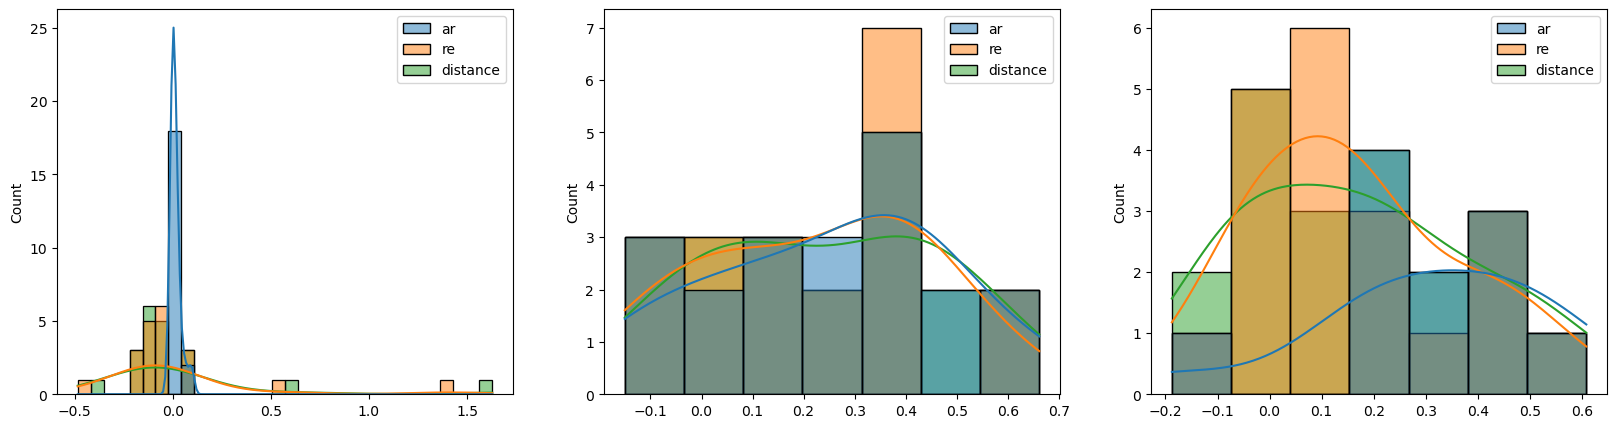

In [122]:
#note that we do not really have enough values for these plots. If we use more countries, or don't take averages of the parameters, it might show a clearer image


import seaborn as sns
import matplotlib.pyplot as plt
frame_use = params.reset_index()
const_frame = frame_use[frame_use["level_1"] == "const"]
L1_frame = frame_use[frame_use["level_1"] == "L1"]
L2_frame = frame_use[frame_use["level_1"] == "L2"]

figures, axis = plt.subplots(1,3,figsize=(20,5))
sns.histplot(
    data = const_frame,
    kde=True,
    ax= axis[0]
)
sns.histplot(
    data=L1_frame,
    kde=True,
    ax= axis[1]
)
sns.histplot(
    data=L2_frame,
    kde=True,
    ax= axis[2]
)


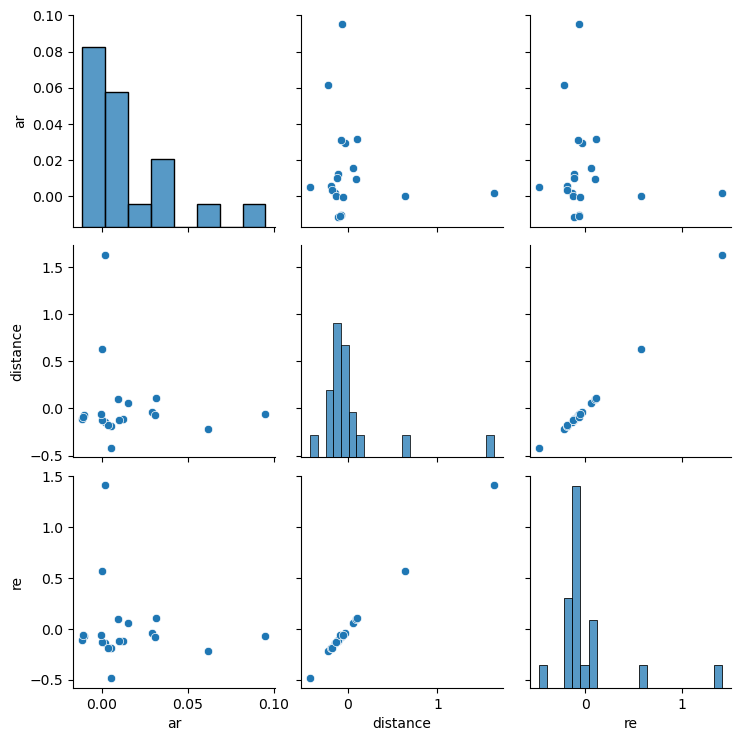

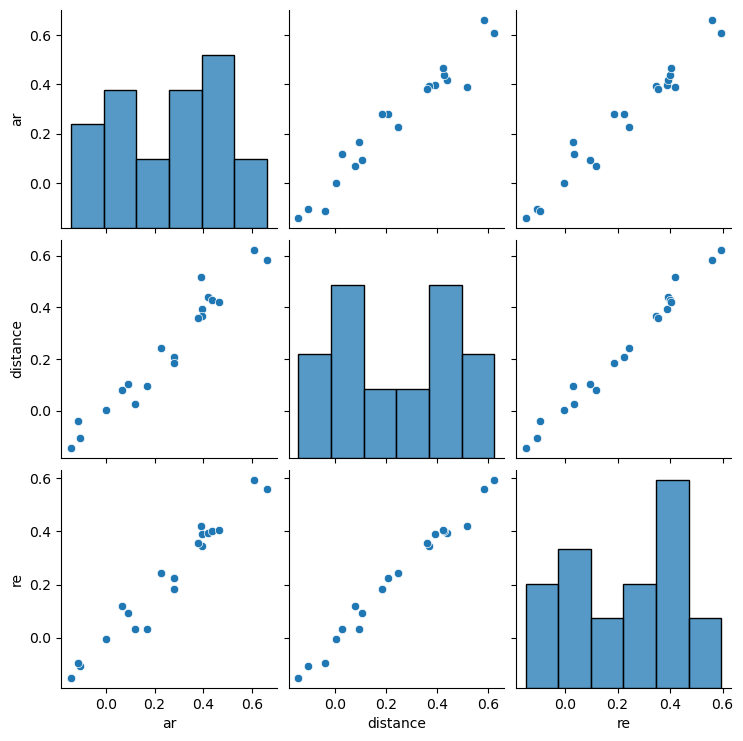

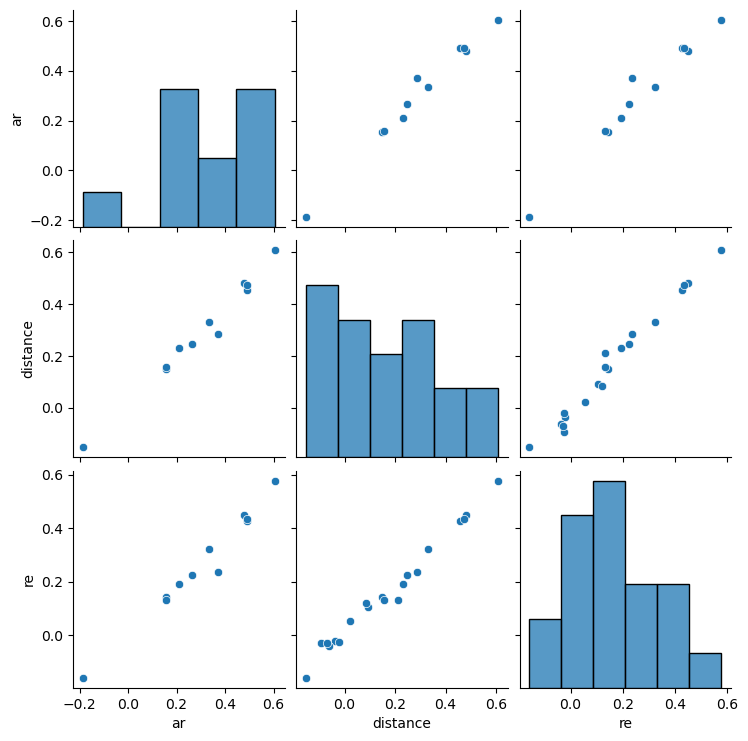

In [141]:
#note that mostly the ar constants are different from the other two models. 
#The lagged coefficients are very similar along models

from mpl_toolkits.mplot3d import Axes3D
sns.pairplot(const_frame[['ar','distance', 're']])
sns.pairplot(L1_frame[['ar','distance', 're']])
sns.pairplot(L2_frame[['ar','distance', 're']])

# Compare forecasts

pred_ar   pred_re  pred_distance
date       country                                         
2010-01-01 Japan         -0.000515  0.001699       0.001567
           Canada         0.004424  0.004185       0.004017
           United States  0.004773  0.007524       0.007462
           Australia      0.008211  0.007992       0.007957
           New Zealand    0.004259  0.008457       0.008591
...                            ...       ...            ...
2023-01-01 Norway         0.005844  0.005291       0.005446
           Belgium        0.017457  0.014176       0.013947
           Korea          0.006778  0.008620       0.009020
           South Africa   0.012069  0.015234       0.015036
2021-01-01 Türkiye        0.025697  0.023905       0.024245

[1060 rows x 3 columns]

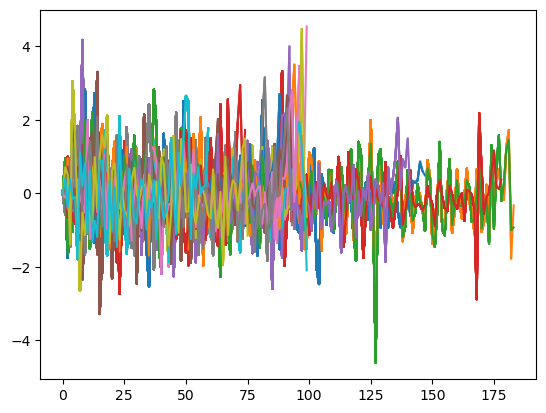

In [125]:
from seminartools.models.utils import h_period_ahead_forecast

preds = pd.concat(
    [
        h_period_ahead_forecast(
            model,
            df,
            h=1,
            start_date="2010-01-01",
        )
        .set_index(["date", "country"])["inflation"].rename(f"pred_{name}")
        #.rename(columns = {"inflation": f"pred_{name}"})
        for model, name in [
            (model_ar, "ar"),
            (model_re, "re"),
            (model_distance, "distance"),
        ]
    ], axis=1
)
preds

In [37]:
merged = preds.merge(df[["inflation", "date", "country"]], left_index=True, right_on = ["date", "country"]).set_index(["date", "country"]).dropna()
merged

pred_ar   pred_re  pred_distance  inflation
date       country                                                    
2010-01-01 Japan         -0.561471 -0.251055      -0.280545  -0.492003
           Canada        -0.492359 -0.512656      -0.538045  -0.494605
           United States -0.496064 -0.168612      -0.176774  -0.585812
           Australia     -0.226603 -0.251271      -0.253833  -0.123970
           New Zealand   -0.349935  0.341370       0.350803  -0.446856
...                            ...       ...            ...        ...
2023-01-01 Netherlands   -0.395664  1.405553       1.526065  -2.493836
           Norway        -0.000380 -0.100293      -0.062378   0.151327
           Belgium        1.717431  1.242304       1.253730  -1.390554
           Korea          0.107024  0.438088       0.499376   0.765687
           South Africa  -0.177712  0.188661       0.191241  -0.288536

[1016 rows x 4 columns]

In [40]:
from sklearn.metrics import mean_squared_error

for col in ["pred_ar", "pred_re", "pred_distance"]:
    print(f"{col}: {mean_squared_error(merged['inflation'], merged[col]):.2g}")

pred_ar: 0.78
pred_re: 1.1
pred_distance: 1.1
